### **MY ETL PIPELINE** 
##### for my LOKA technical interview

The porpouse of this introductory project is to show familiarity, curiosity and interest with the skills requiered for the position. I'll be incorporating  a data pipeline by extracting data from a NoSQL database, cleaning it, tranfering useful structured information to a  SQL database, and uploading the cleaned data to aws(s3). All of this ofcourse using relevant python libraries. Also I will be showing analytical insights and  as a bonus  will be applying a simple ML model to the data for prediction. 

In [62]:
from pymongo import MongoClient #For Mongodb-python connection

import sqlalchemy
from sqlalchemy import create_engine  #SQL-python Connection

import boto3
import io                            #Python-aws(s3) connection

import pandas as pd
import matplotlib.pyplot as plt      #Data treatment and visualization
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer                          
from sklearn.linear_model import SGDClassifier                           #Sklearn for classification model
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from dotenv import load_dotenv, dotenv_values
import os


In [80]:
load_dotenv(".env") #Loading personal credentials

True

#### EXTRACTING

Here we will be extracting a collection called *ChurnDataTrain* from a database called *appdb* stored in Mongodb.  This collection contains a dataset with information about customers with an important field stating if the costumers churned or not. In this case I used a got this dataset from  (https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset) but the idea is to asume the data was stored there in the first place. Also, I know is more "convinient" to store structured data in a SQL-type database managment system, but for the porpuse of showing familiarity with a No-SQL type DBMSs I decided to initially store it in Mongodb.

In [66]:
host=os.getenv('HOST')
client = MongoClient(host)         #Conect to Mongodb # To specify a port  do your_host:your_port
db=client.appdb                    #Acces the database
train=db.ChurnDataTrain            #Acces the collection

Next we do an initial check in the data to confirm I uploaded correctly

In [7]:
#Checking the data 
print([p for p in train.find()][:5]) 

[{'_id': ObjectId('67f161e58517a6f024d34322'), 'CustomerID': 2, 'Age': 30, 'Gender': 'Female', 'Tenure': 39, 'Usage Frequency': 14, 'Support Calls': 5, 'Payment Delay': 18, 'Subscription Type': 'Standard', 'Contract Length': 'Annual', 'Total Spend': 932, 'Last Interaction': 17, 'Churn': 1}, {'_id': ObjectId('67f161e58517a6f024d34323'), 'CustomerID': 4, 'Age': 55, 'Gender': 'Female', 'Tenure': 14, 'Usage Frequency': 4, 'Support Calls': 6, 'Payment Delay': 18, 'Subscription Type': 'Basic', 'Contract Length': 'Quarterly', 'Total Spend': 185, 'Last Interaction': 3, 'Churn': 1}, {'_id': ObjectId('67f161e58517a6f024d34324'), 'CustomerID': 5, 'Age': 58, 'Gender': 'Male', 'Tenure': 38, 'Usage Frequency': 21, 'Support Calls': 7, 'Payment Delay': 7, 'Subscription Type': 'Standard', 'Contract Length': 'Monthly', 'Total Spend': 396, 'Last Interaction': 29, 'Churn': 1}, {'_id': ObjectId('67f161e58517a6f024d34325'), 'CustomerID': 6, 'Age': 23, 'Gender': 'Male', 'Tenure': 32, 'Usage Frequency': 20, '

All Mongodb documents have a distintc auto-generated field with the name *_Id* given the fact that the dataset already contains a field called *Costumer ID* the *_Id* won't be necessary. Also *Costumer ID* only contains numbers, but *_Id* containd numbers and letters, wich simplifies things in the long run.

In [8]:
#Dropping the ObjectId
pTrain=list(train.find({}, {'_id': 0}))    


#Checking the Id was dropped
print([p for p in pTrain[:5]])   

[{'CustomerID': 2, 'Age': 30, 'Gender': 'Female', 'Tenure': 39, 'Usage Frequency': 14, 'Support Calls': 5, 'Payment Delay': 18, 'Subscription Type': 'Standard', 'Contract Length': 'Annual', 'Total Spend': 932, 'Last Interaction': 17, 'Churn': 1}, {'CustomerID': 4, 'Age': 55, 'Gender': 'Female', 'Tenure': 14, 'Usage Frequency': 4, 'Support Calls': 6, 'Payment Delay': 18, 'Subscription Type': 'Basic', 'Contract Length': 'Quarterly', 'Total Spend': 185, 'Last Interaction': 3, 'Churn': 1}, {'CustomerID': 5, 'Age': 58, 'Gender': 'Male', 'Tenure': 38, 'Usage Frequency': 21, 'Support Calls': 7, 'Payment Delay': 7, 'Subscription Type': 'Standard', 'Contract Length': 'Monthly', 'Total Spend': 396, 'Last Interaction': 29, 'Churn': 1}, {'CustomerID': 6, 'Age': 23, 'Gender': 'Male', 'Tenure': 32, 'Usage Frequency': 20, 'Support Calls': 5, 'Payment Delay': 8, 'Subscription Type': 'Basic', 'Contract Length': 'Monthly', 'Total Spend': 617, 'Last Interaction': 20, 'Churn': 1}, {'CustomerID': 8, 'Age':

As we knew from the beggining that the data had a structured format (all documents share the same fields), we will be readind it with pandas, an generating a dataset.

In [9]:
dfTn=pd.DataFrame(pTrain) #creating a dataframe for pTrain

#Checking
dfTn.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30,Female,39,14,5,18,Standard,Annual,932,17,1
1,4,55,Female,14,4,6,18,Basic,Quarterly,185,3,1
2,5,58,Male,38,21,7,7,Standard,Monthly,396,29,1
3,6,23,Male,32,20,5,8,Basic,Monthly,617,20,1
4,8,51,Male,33,25,9,26,Premium,Annual,129,8,1


In [10]:
#Making sure the number of rows is the xpected.
dfTn.shape

(440833, 12)

In [11]:
#Checking the data types
dfTn.dtypes


CustomerID           object
Age                  object
Gender               object
Tenure               object
Usage Frequency      object
Support Calls        object
Payment Delay        object
Subscription Type    object
Contract Length      object
Total Spend          object
Last Interaction     object
Churn                object
dtype: object

We can see all datatypes for our columns are objects, the reason is  our column values used to be mongodb documents wich can be understood as an object without methods. We  

In [12]:
#Converting form object to more "workable" types Tn

numCols= ['CustomerID','Age', 'Tenure','Usage Frequency',	'Support Calls','Payment Delay', 'Total Spend',	'Last Interaction',	'Churn'] #Numerical Columns
CatCols= ['Gender', 'Subscription Type',	'Contract Length'] #Cathegorical Columns

for row in numCols:
    dfTn[row] = pd.to_numeric(dfTn[row], downcast='float') 
    
for row in CatCols:
    dfTn[row] = dfTn[row].astype('string')
dfTn.dtypes

CustomerID                  float32
Age                         float32
Gender               string[python]
Tenure                      float32
Usage Frequency             float32
Support Calls               float32
Payment Delay               float32
Subscription Type    string[python]
Contract Length      string[python]
Total Spend                 float32
Last Interaction            float32
Churn                       float32
dtype: object

In [13]:
#Sorting by Costumer ID Tn
dfTn = dfTn.sort_values(by='CustomerID', ascending=True)
dfTn.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
7,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
1,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
2,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
3,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


Now we are going to focus in  cleaning the data and prepping it for future analysis.

In [14]:
dfTn.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,440832.0,225398.750000,129531.914062,2.0,113621.75,226125.5,337739.25,449999.0
Age,440832.0,39.373150,12.442369,18.0,29.00,39.0,48.00,65.0
Tenure,440832.0,31.256336,17.255728,1.0,16.00,32.0,46.00,60.0
Usage Frequency,440832.0,15.807493,8.586242,1.0,9.00,16.0,23.00,30.0
Support Calls,440832.0,3.604437,3.070218,0.0,1.00,3.0,6.00,10.0
Payment Delay,440832.0,12.965722,8.258062,0.0,6.00,12.0,19.00,30.0
Total Spend,440832.0,631.616272,240.803009,100.0,480.00,661.0,830.00,1000.0
Last Interaction,440832.0,14.480868,8.596208,1.0,7.00,14.0,22.00,30.0
Churn,440832.0,0.567107,0.495477,0.0,0.00,1.0,1.00,1.0


##### Some initial Observations:

There was very little information about the units of the columns where I obtained the dataset (https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset) So I'll make some informed asumptions about them with this initial statistics.

* The service only takes adult costumers (if the legal age in the data's country is 18).

* given the fact that the mean for age is 39 (wich can safely be asumed is in years), the mean for tenure is 31 and the minimum costumer age is 18, it wouldnt make sense for tenure to be in years, so I'll assume it's in months. Also the company seems to have a policy of a one month tenutre minimum.

* I'll also asume the usage frecuency its given in times per month, due to the fact that if it was times per tenure the user(s) that have a maximum tenure (we can see is 5 years) only would have used the services once every two months maximum (30 is the maximum usage frecuency). Also it makes senses that the maximum usage per month is close to the average days of a month (30), wich can perhaps indicate the service can be used once per day.

* The support calls indicator doesnt says if its a frecuency or is the total number in the tenure period, both could make sense given the fact that some services one can have for a very long time and never make a support call, for others it can be needed very often; But in this case I'll assume it is given in calls per month because the mean of churned customer is around 0.5, that is almost half the costumers in this dataset have quited the services. wich means the satisfaction cant be that high, and when the satisfaction is not very high it is more likely that costumer will make support calls to complain or to ask for help more often.

* Since I determined the tenure in months, I'll asume the payment delay in days. Also the max payment delay being 30 indicates that maybe the service is cancelled after one month delay, wich makes sense and can be seen in a lot of company policies.

* Just for globality reasons I'll assume the total spend in dollars. Also I will not be assuming it as a relation (That is dollars per some unit of time) becasue I think the maximum spent is plausible if we were to assign it to the maximum tenure.  So it will be maximum spent in total for the whole tenure period.

* For the same reason given for payment delay I'll be assuming the last interaction (since the data was collected ofc) in days.

* Churn 1: yes (the customer churned), 0: no (the cosutumer didn't) churn, because of convention.

So in summary we'll work with:

**Age** in **Years** \
**Tenure** in **Months** \
**Usage Frecuency** in **Times per Month** \
**Support Calls** in **Calls per Month** \
**Payment delay** in **Days** \
**Total Spend** in **Dollars** \
**Last Interaction** in **Days** \
**Churn**:  1:yes  0:no

That being set, let us get to clean the data for possible errors, problematic outliers, inconsistencies or unuseful values.

In [15]:
#This function checks for duplicated considering all columns except by the ones specified in exclude_columns
def count_duplicates_excluding(df, exclude_columns):
    check_df = df.drop(columns=exclude_columns)
    duplicates = check_df[check_df.duplicated()]
    return len(duplicates), duplicates

In [16]:
count, dup_rows = count_duplicates_excluding(dfTn, exclude_columns=['CustomerID', 'Churn'])
print(f"Number of duplicated rows (excluding CustomerID and Churn): {count}")  #Because maybe the system sets a  different customer id to every customer even if the information is duplicated, and excluding churn in case theres a customer that churned and came back so has two different values in the data.
print(dup_rows)

Number of duplicated rows (excluding CustomerID and Churn): 0
Empty DataFrame
Columns: [Age, Gender, Tenure, Usage Frequency, Support Calls, Payment Delay, Subscription Type, Contract Length, Total Spend, Last Interaction]
Index: []


It seems like theres no duplicated data in this data set. But if the costumer had a document like their goverment id in the data we could be more secure of that 

In [ ]:
#Now lets check for blank values or errors in the columns with string datatypes
def count_string_values(df, column):                             # This function returns the number of repetitions per string value in a column 
    value_counts = df[column].value_counts()
    result = "\n".join([f"{val}: {count}" for val, count in value_counts.items()])
    return result

In [ ]:
#Using the function in the cathegorical values to check for mispelled words or blank values
for column in CatCols: print(count_string_values(dfTn, column), "\n") 

Male: 250252
Female: 190580
: 1 

Standard: 149128
Premium: 148678
Basic: 143026
: 1 

Annual: 177198
Quarterly: 176530
Monthly: 87104
: 1 



In [19]:
#Since we found  blank values are going now to look for the rows containing them
for column in CatCols: print(dfTn[dfTn[column] == ''], "\n")

        CustomerID  Age Gender  Tenure  Usage Frequency  Support Calls  \
199295         NaN  NaN            NaN              NaN            NaN   

        Payment Delay Subscription Type Contract Length  Total Spend  \
199295            NaN                                            NaN   

        Last Interaction  Churn  
199295               NaN    NaN   

        CustomerID  Age Gender  Tenure  Usage Frequency  Support Calls  \
199295         NaN  NaN            NaN              NaN            NaN   

        Payment Delay Subscription Type Contract Length  Total Spend  \
199295            NaN                                            NaN   

        Last Interaction  Churn  
199295               NaN    NaN   

        CustomerID  Age Gender  Tenure  Usage Frequency  Support Calls  \
199295         NaN  NaN            NaN              NaN            NaN   

        Payment Delay Subscription Type Contract Length  Total Spend  \
199295            NaN                              

We found an unuseful rows, we are going to drop them and look for more rows with Nan values.

In [20]:
# Drop rows where any of these columns are empty strings or just whitespace
dfTn = dfTn[~dfTn[CatCols].apply(lambda x: x.str.strip() == '').any(axis=1)]

In [21]:
#Looking for more Nans
print(dfTn.isna().sum())

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


In [22]:
#Looking for repeated IDs
duplicate_ids = dfTn[dfTn['CustomerID'].duplicated(keep=False)]

# Display them sorted for clarity
print(duplicate_ids.sort_values('CustomerID'))

Empty DataFrame
Columns: [CustomerID, Age, Gender, Tenure, Usage Frequency, Support Calls, Payment Delay, Subscription Type, Contract Length, Total Spend, Last Interaction, Churn]
Index: []


In [23]:
#Now we llok for values different from 1 or 0 in churn 
dfTn[~dfTn['Churn'].isin([0, 1])] 

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn


It seems we don't have Churn values different from 0 or 1, wich would be very problematic otherwise

Now for the Numerical Columns we will be plotting histograms with strategically chosen intervals, and boxplots because this ones give us information about the data distribution and highlight outliers.

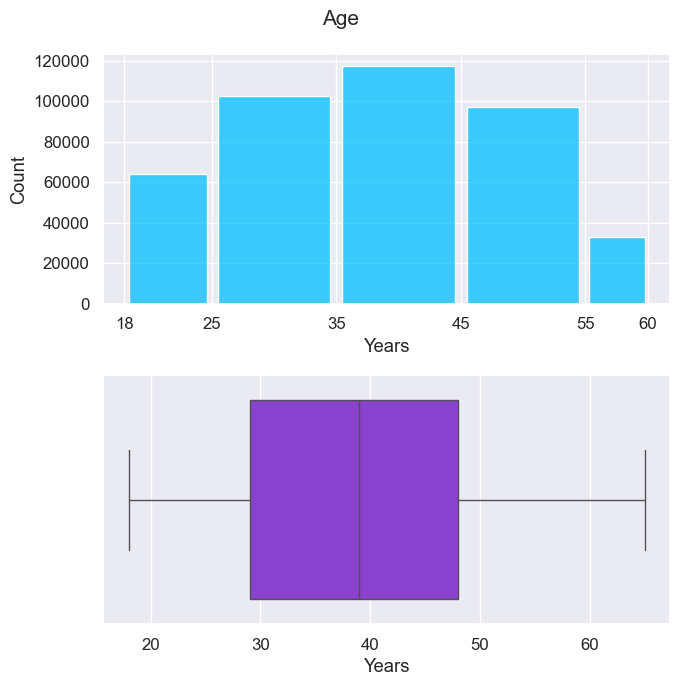

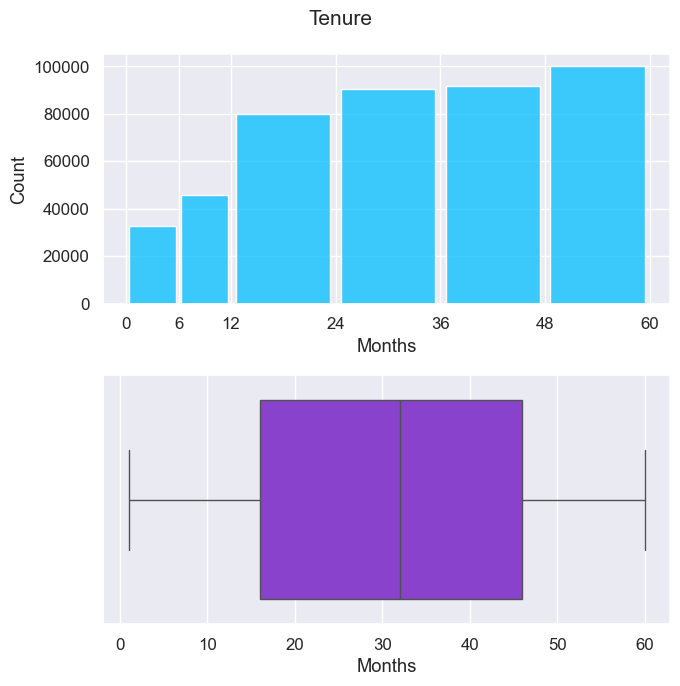

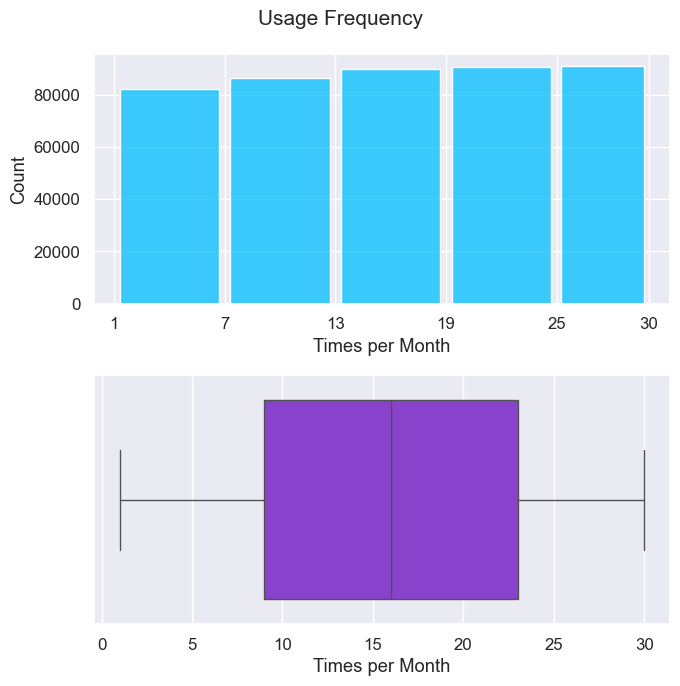

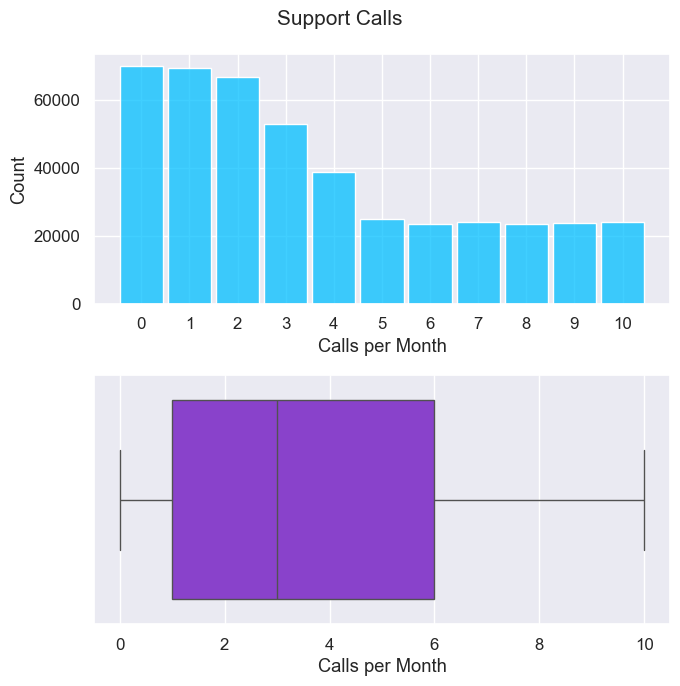

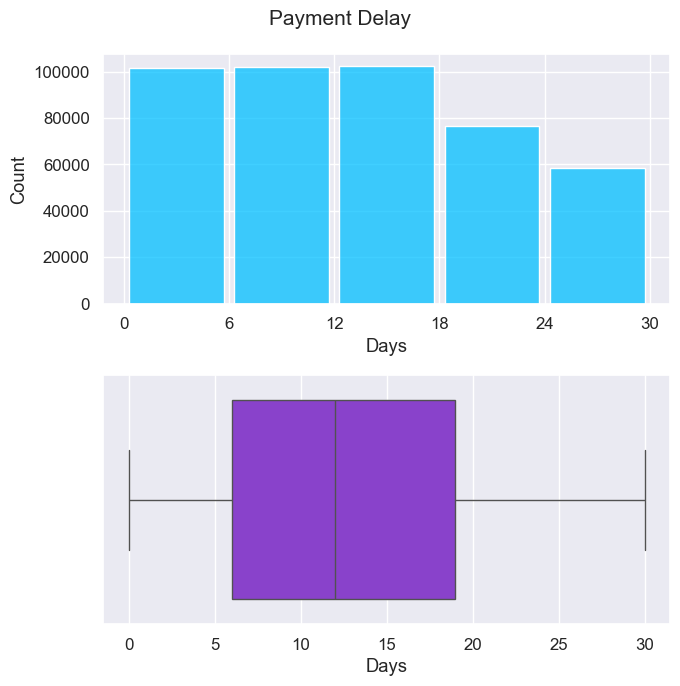

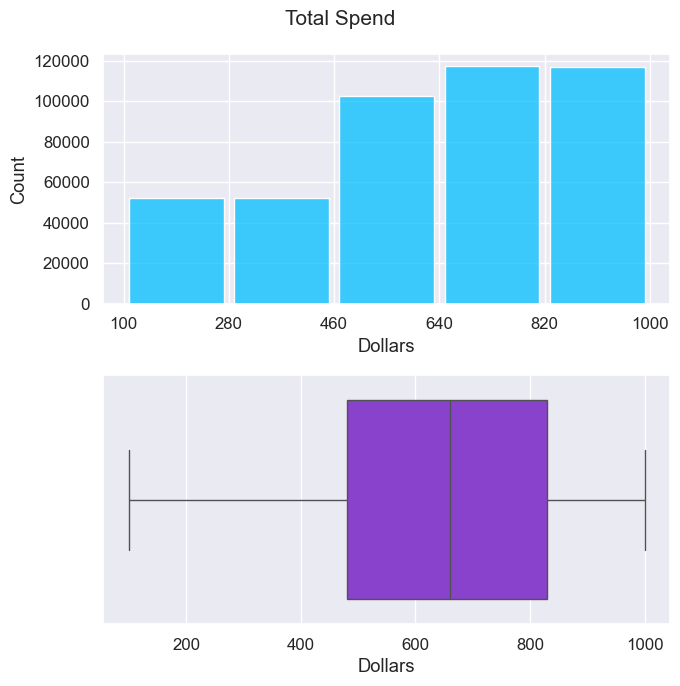

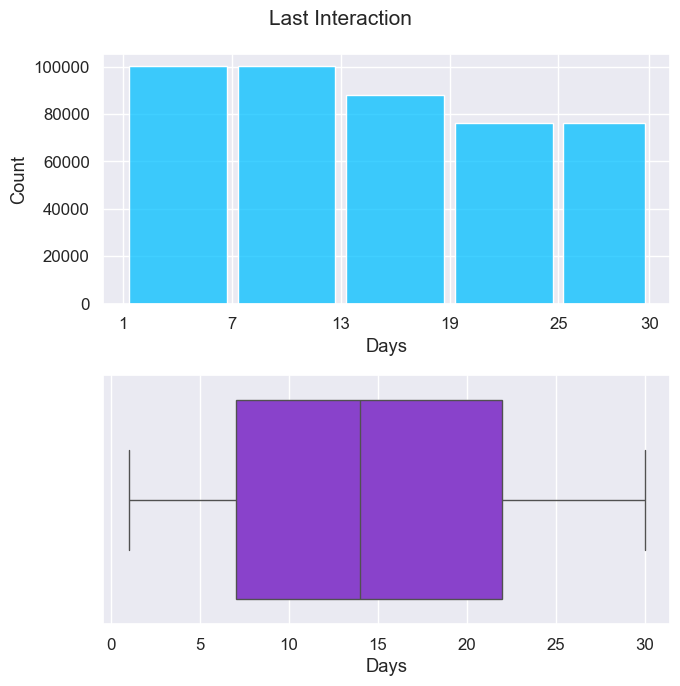

In [24]:
#Looking for outliers in the numerical columns and visualizing data

bin=[[18, 25, 35, 45, 55, 60],[0,6,12,24,36,48,60],[1,7,13,19,25,30],np.arange(11),5,5,[1,7,13,19,25,30]]
units=['Years','Months','Times per Month','Calls per Month', 'Days', 'Dollars', 'Days']

sns.set_theme(font_scale=1.1)

for i, col in enumerate(numCols[1:-1]):
    fig,ax = plt.subplots(2,1,figsize=(7,7),tight_layout=True)
    fig.suptitle(col,size=15)
    data=dfTn[col]
    
    if i != 3: 
        sns.histplot(x=data,ax=ax[0],color='deepskyblue', bins=bin[i], element='bars', shrink=0.9)
        bin_edges = np.histogram_bin_edges(data, bin[i])
        ax[0].set_xticks(bin_edges)
        
    else:
        sns.histplot(x=data,ax=ax[0],color='deepskyblue', bins=bin[i], element='bars', shrink=0.9, discrete=True)
        ax[0].set_xticks(bin[i])
        
    sns.boxplot(x=data,ax=ax[1],color='blueviolet')
    ax[0].set_xlabel(units[i])
    ax[1].set_xlabel(units[i])
    plt.show()

The age column tells us that most users are around their 30s and 40s the company could implement strategies to reach the youngest and oldest users. about the other columns it would be more insightful  to see this graphs for churned and not churned uses separetly and compare them, wich can totally be done. Also we don't observe outliers that could affect predictions in the box plots.

Now let's see some piecharts for the string valued variables:

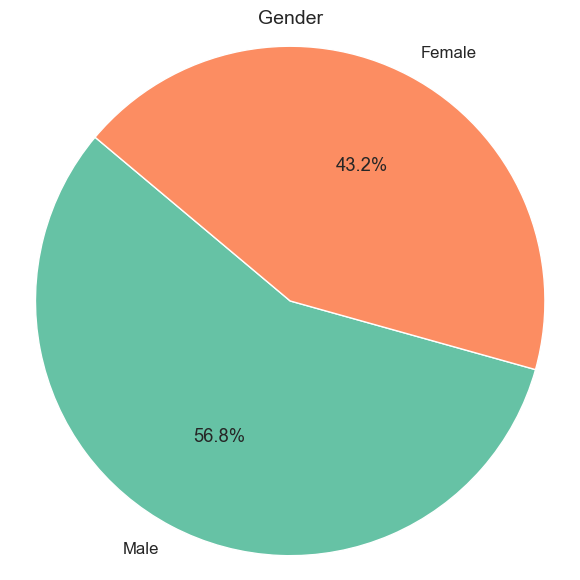

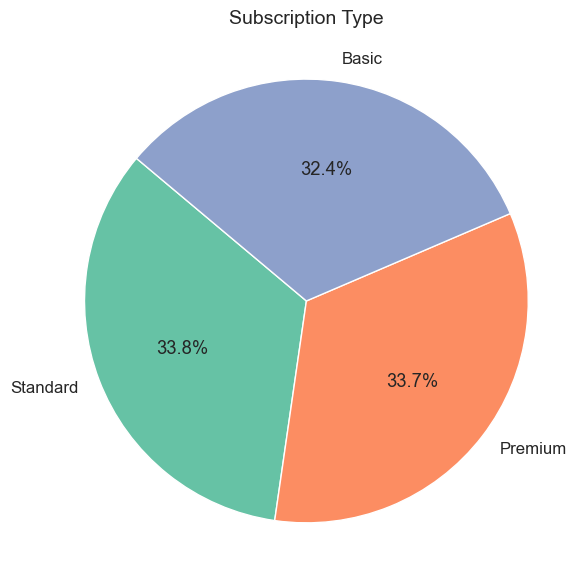

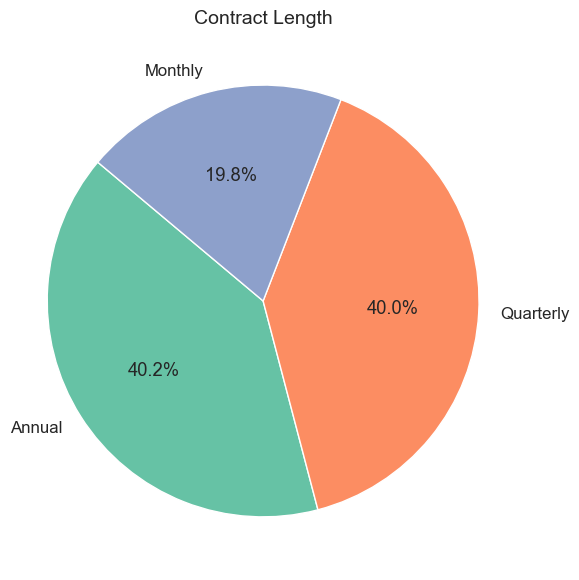

In [26]:
for col in catCols:
    # Get value counts
    counts = dfTn[col].value_counts()

    # Create pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=plt.cm.Set2.colors
    )
    plt.title(col, fontsize=14)
    plt.axis('equal')  # Ensures pie is a circle
    plt.tight_layout()
    plt.show()


Let's suppose now that the company needs an speccific information about data uploaded to MySQL, in this case the average Tenure and Total Spend
per subscription type.

##### Transfering a table to MYSQL

In [32]:
#First we crete the table. In this case we'll group by Subscription Type and find the average Tenure and Total Spend

avg_SubsType = dfTn.groupby('Subscription Type')[['Tenure', 'Total Spend']].mean().T

# Rename the rows
avg_SubsType.index = ['Average Tenure', 'Average Spend']

avg_SubsType

Subscription Type,Basic,Premium,Standard
Average Tenure,31.935347,30.883459,30.976858
Average Spend,628.673523,632.926453,633.132263


In [ ]:
#Connecting to MySQL 
user=os.getenv("USER_")
psw=os.getenv('PSW')
con_string = f"mysql+mysqldb://{user}:{psw}@{host}/churn_db"
engine=create_engine(con_string)

root


In [75]:
avg_SubsType.to_sql(name='av_sub', con=engine, if_exists='replace', index=False)

2

In [76]:
pd.read_sql("SELECT * FROM avg_Subs;", con=engine)

,Basic,Premium,Standard
0,31.9353,30.8835,30.9769
1,628.6740,632.9260,633.1320


### Now lets upload the clean data to aws s3

Knowing that we already checked for problematics values, we we'll upload the complete cleaned dataset to s3.

In [ ]:
acces_key=os.getenv("ACCES")
secret_key=os.getenv("SECRET")
bucket=os.getenv("BUCKET")

# Creating a session and S3 client
session = boto3.Session(
    aws_access_key_id=acces_key,
    aws_secret_access_key=secret_key, 
    
    region_name='us-east-2'
)
s3 = session.client('s3')

# Converting DataFrame to CSV in memory
csv_buffer = io.StringIO()
dfTn.to_csv(csv_buffer, index=False)

# Upload to S3
s3.put_object(
    Bucket=bucket,
    Key='clean_churn_data.csv',
    Body=csv_buffer.getvalue()
)

#### ML Model

Now we will use the data to implement a simple classification model that determines wether a user is going to churn or not. 

The first thing we will do is check for any important correlation in the variables so that we can decided wether or not use PCA

<Figure size 1000x800 with 0 Axes>

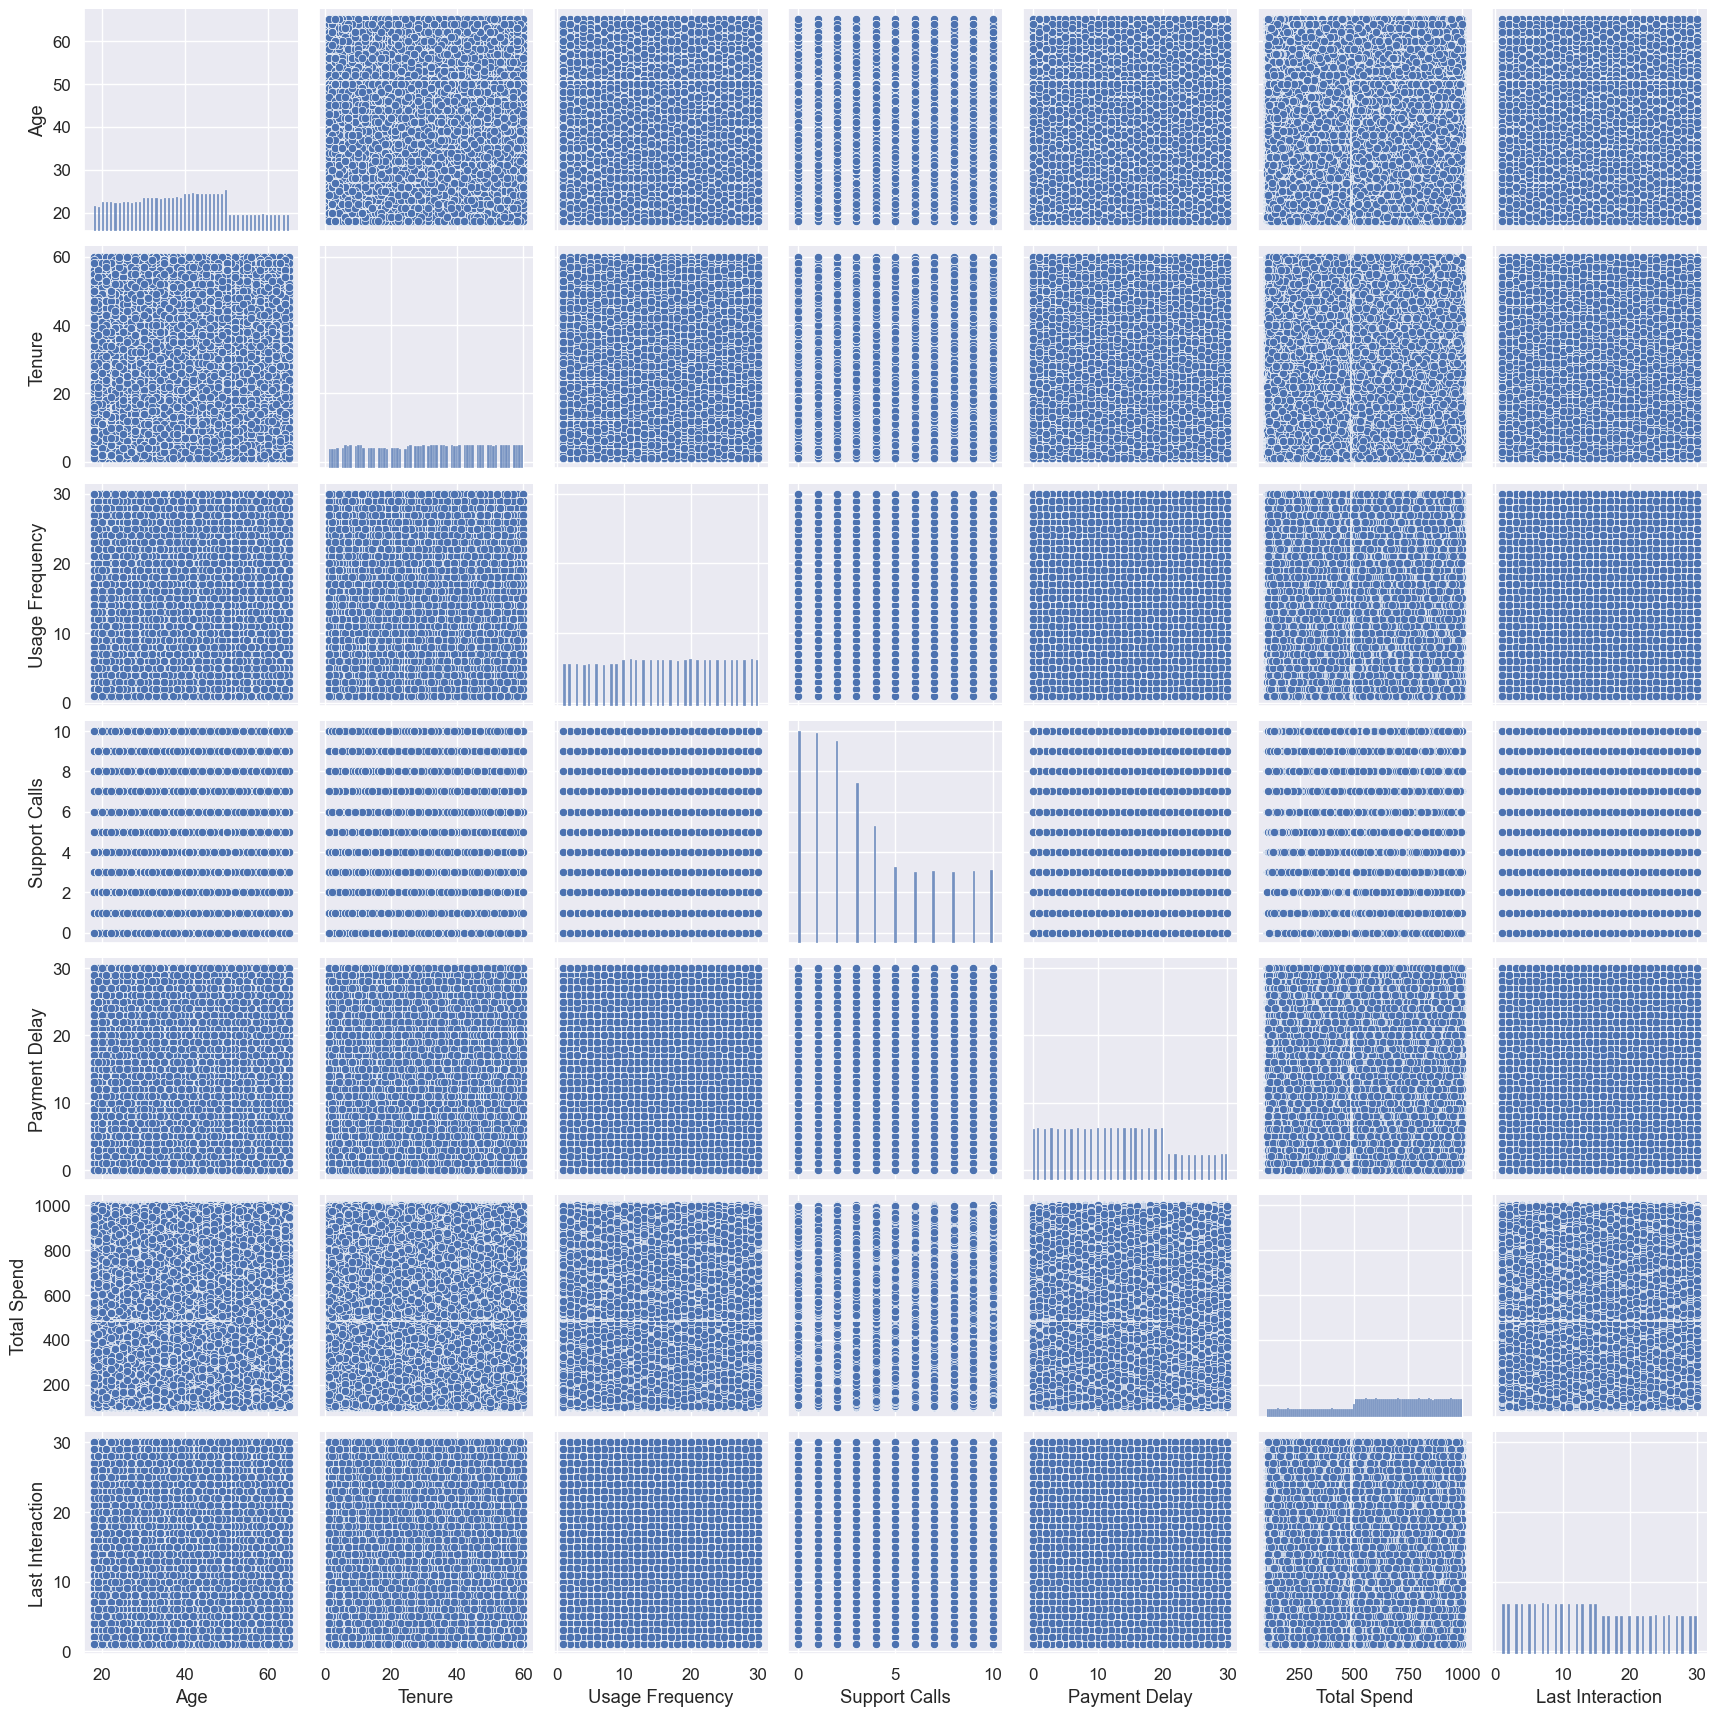

In [83]:
#Now I will look at the data correlations to see if its usefull to use PCA 
plt.figure(figsize=(10,8))
sns.pairplot(dfTn.iloc[:, 1:-1])
plt.show()

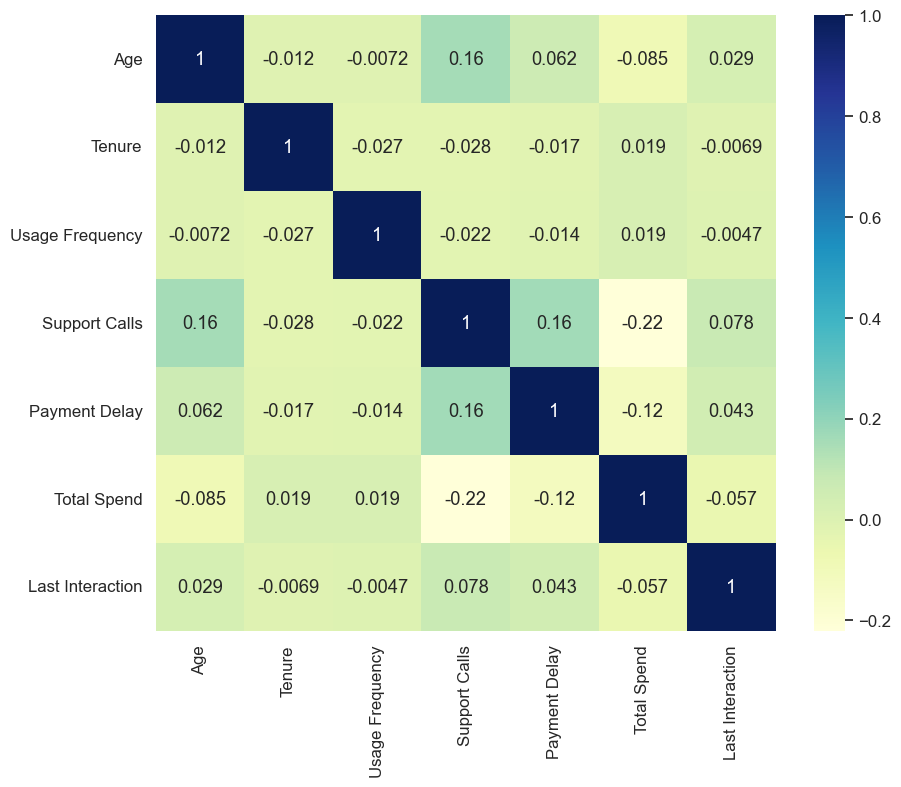

In [85]:

dfTn1=dfTn[numCols[1:-1]]
plt.figure(figsize=(10,8))
sns.heatmap(dfTn1.corr(), cmap="YlGnBu", annot=True)
plt.show()

There are NO significant correlations to use PCA, so we will not be using it.

### Now we implement an Stochastic Gradient Descent (SGD) model 

In [86]:


# 1. Cathegorize Features & target
numerical_features = numCols[1:-1]
categorical_features = CatCols
target = 'Churn'

X = dfTn[numerical_features + categorical_features]
y = dfTn[target]

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 4. Full pipeline (preprocessing + classifier)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, random_state=42))
])

# 5. Fit the model
pipeline.fit(X_train, y_train)

# 6. Evaluate the model
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88     38167
         1.0       0.92      0.89      0.90     50000

    accuracy                           0.89     88167
   macro avg       0.89      0.89      0.89     88167
weighted avg       0.89      0.89      0.89     88167



In [87]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the matrix as text
print("Confusion Matrix:\n", cm)

# Optionally, display it as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

Confusion Matrix:
 [[34085  4082]
 [ 5482 44518]]


The model has "okay" scores in general terms, but it can be improved further exploring more characteristics or even trying different algorithms to reduce the secondary diagonal of the confusion matrix. A further step for this project could be automatizing this process with an ADG airflow, also some processes could be paralelized with DASK